# Chapter 3 Code - Steering Evolution with Sequential Therapy

Presented below is the Python code used to generate the results presented in Chapter 3. This code is partially adapted from the Github repository with doi:10.5281/zenodo.27481 published alongside the following paper:

__Nichol, Daniel, et al. "Steering evolution with sequential therapy to prevent the emergence of bacterial antibiotic resistance" PLoS computational biology 11.9 (2015): e1004493__

and is also used to generate the results in the following preprint:

__Nichol, Daniel, et al. "Collateral sensitivity is contingent on the repeatability of evolution." bioRxiv (2017): 185892.__

Note that where a sample size is specified, the number of samples has been reduced (from the value used in the thesis) to ensure that this notebook can be evaluated without long pauses.

## Prerequisites

In [5]:
from copy import deepcopy
import glob
import math
import random
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import Grid
import numpy as np
import seaborn as sns

print "Python version: ", sys.version
print "numpy version: ", np.__version__
print "matplotlib version: ", matplotlib.__version__

%matplotlib inline

Python version:  2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version:  1.11.3
matplotlib version:  2.0.2


## Helper functions

Here we represent genotypes as binary strings and landscapes as lists of values. As such, it is useful to define a collection of helper functions to translate between a binary string its equivalent index in the fitness landscape.

In [6]:
#==============================================================================#
# Helper functions
#==============================================================================#
# Computes the hamming distance between two genotypes.
def hammingDistance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Takes a genotype and converts it to an integer use indexing 
# the fitness landscape list 
def convertGenotypeToInt(genotype):
    out = 0
    for bit in genotype:
        out = (out << 1) | bit
    return out

# Converts an integer to a genotype by taking the binary value and 
# padding to the left by 0s
def convertIntToGenotype(anInt, pad):
    offset = 2**pad
    return [int(x) for x in bin(offset+anInt)[3:]]

# Function which returns all genotypes at Hamming distance 1 from a 
# specified genotype
def getOneStepNeighbours(genotype):
    neighbours = []
    for x in range(0, len(genotype)):
        temp = deepcopy(genotype)
        temp[x] = (genotype[x]+1) %2 #There is some inefficiency here.
        neighbours.append(temp)
    return neighbours

## A Fitness Landscape Class

In [7]:
#==============================================================================#
# Defining a fitness landscape class
#
# This class represents a fitness landscapes as a list of fitness values 
# (self.landscape) and provdes a collection of useful methods of 
# querying the landscape
#==============================================================================#
class FitnessLandscape:
    def __init__(self, landscapeValues, name=None):
        self.landscape = landscapeValues
        self.name = name

    def getFitness(self, genotype):
        fitness = self.landscape[convertGenotypeToInt(genotype)]
        return fitness

    def genotypeLength(self):
        return int(math.log(len(self.landscape), 2))

    def numGenotypes(self):
        return len(self.landscape)

    def isPeak(self, g):
        peak = True
        for h in getOneStepNeighbours(g):
            if self.getFitness(g) < self.getFitness(h):
                peak = False
                break
        return peak

    def getPeaks(self):
        peaks = []

        allGenotypes = []
        N =self.genotypeLength()
        for x in range(0, 2**N):
            allGenotypes.append(convertIntToGenotype(x, self.genotypeLength()))

        for g in allGenotypes:
            if self.isPeak(g):
                peaks.append(g)

        return peaks

    def getGlobalPeak(self):
        return convertIntToGenotype(np.argmax(self.landscape), self.genotypeLength())
    
    def getLowestFitnessPeak(self):
        # Finds the peaks of the landscape
        peak_genotypes = self.getPeaks()
        lowest_peak_genotype = peak_genotypes[
            np.argmin([self.getFitness(g) for g in peak_genotypes])]
        return lowest_peak_genotype

## Kauffman's $NK$ Model
We implement Kauffman's $NK$ model for generating tuneable rugged fitness landscapes. In the text of the thesis we refer to this model as the $LK$ model to avoid confusion with the use of $N$ to represent population size in the population genetics literature. $NK$ landscapes were introduced in the following publication:

__Kauffman, Stuart A., and Edward D. Weinberger. "The NK model of rugged fitness landscapes and its application to maturation of the immune response." Journal of theoretical biology 141.2 (1989): 211-245.__

In [13]:
# For each possible value of (x_i;x_{i_1}, ... , x_{i_K}) 
# we have a random number sampled from [0,1)
def geneWeights(K,N):
    return [[random.random() for x in range(2**(K+1))] for y in range(N)]

# Given a genotype length (N) and the number of alleles (K) 
# this function randomly choses K alleles from positions {1,...N}\{i} 
# which interact epistatically with the ith position
def buildInfringersTable(N,K):
    return [random.sample(range(i)+range(i+1,N),K) for i in range(N)]

# Builds a tuple for look up in the fitness table from the infringers list
def buildTuple(allele, i, infringers):
    tp = [allele[i]]
    for j in infringers:
        tp += [allele[j]]
    return tp

# Given an allele computes the fitness by building a tuple of revelant infringers
# and looks them up in the gene weights table
def alleleFitness(allele, gw, infrs, N, K):
    s = 0.
    for i in range(N):
        index = buildTuple(allele,i,infrs[i])
        s += gw[i][convertGenotypeToInt(index)]
    s = s / N
    return s

#Generates an N-K landscape from Kauffman's method.
def generateNKLandscape(N,K):
    gw = geneWeights(K,N)
    infrs = buildInfringersTable(N,K)
    landscape = [alleleFitness(convertIntToGenotype(a,N), gw, infrs, N, K) \
                 for a in range(2**N)]
    return FitnessLandscape(landscape)

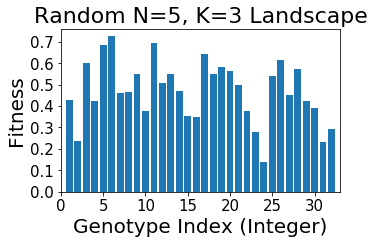

In [14]:
# Example use:
plt.figure(figsize=(5,3))
f1 = generateNKLandscape(5,3)
plt.bar(range(1,33), f1.landscape)
plt.xlim(0,33)
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('Genotype Index (Integer)', size=20)
plt.ylabel('Fitness', size=20)
plt.title('Random N=5, K=3 Landscape', size=22);

## Markov Model

Here we implement the Markov chain model defined in Section 3.1

In [15]:
#==============================================================================#
# Equations 3.1, 3.2, 3.3 and 3.4
#
# Given two genotypes and a landscape, computes the transition probability
# Pr(g1->g2) in the markov chain transition matrix
#==============================================================================#
def transProbSSWM(g1, g2, landscape, r=0):
    # Equation 3.1
    # If the genotypes are more than one mutation apart, then 0
    if hammingDistance(g1,g2) > 1:
        return 0

    #Else compute Pr(g1->g2) from Equation 3.2 and 3.3
    elif hammingDistance(g1,g2) == 1:
        #Equation 3.2
        if landscape.getFitness(g1) >= landscape.getFitness(g2):
            return 0
        #Equation 3.3
        else:
            num = (landscape.getFitness(g2) - landscape.getFitness(g1))**r
            den = 0.
            for genotype in getOneStepNeighbours(g1):
                fitDiff = (landscape.getFitness(genotype) - landscape.getFitness(g1))
                if fitDiff > 0:
                    den += fitDiff**r
            return num / den

    #Finally add in those Pr(g1->g1)=1 for g1 a local optima (Equation 3.4)
    else:
        isPeak = landscape.isPeak(g1)
        return int(isPeak)

In [16]:
#==============================================================================#
# Equation 3.5
#
# Builds the transition matrix for a given landscape
#==============================================================================#
def buildTransitionMatrix(landscape, r=0):
    genomeLen = landscape.genotypeLength()
    matList = [[transProbSSWM(convertIntToGenotype(i,genomeLen), 
                              convertIntToGenotype(j, genomeLen), landscape, r) \
                for j in range(0, 2**genomeLen)] for i in range(0, 2**genomeLen)]
    return np.matrix(matList)

In [17]:
#==============================================================================#
# Computes P* from P (Equation 3.8)
#
# Given a stochastic matrix P, finds the limit matrix 
#==============================================================================#
def limitMatrix(P):
    Q = np.identity(len(P))
    while not np.array_equal(Q,P):
        Q = deepcopy(P)
        P = P*P #Square P until it no longer changes.
    return P

## Commutativity Test 
Here we demonstrate the non-commutativity of evolution, these results are listed in Section 3.2.1. This test serves as a simple example demonstrating the use of the Markov chain model defined above.

In [18]:
%%time
num_samples = 10**1 #10**6 #In the paper/thesis
commuting_pairs = []
N = 5
for i in range(num_samples):
    K_1 = random.randint(0,N-1)
    K_2 = random.randint(0,N-1)

    l_1 = generateNKLandscape(N,K_1)
    l_2 = generateNKLandscape(N,K_2)

    limit_1 = limitMatrix(buildTransitionMatrix(l_1))
    limit_2 = limitMatrix(buildTransitionMatrix(l_2))

    if (limit_1*limit_2 == limit_2*limit_1).all():
        commuting_pairs.append((l_1, l_2))

print len(commuting_pairs) / float(num_samples) #Approx 0.132% for a large sample.

0.0
CPU times: user 416 ms, sys: 7.95 ms, total: 424 ms
Wall time: 429 ms


## Model Parametrisation
The following as the landscapes derived by Mira et al in the following paper.

__Mira, Portia M., et al. "Rational design of antibiotic treatment plans: a treatment strategy for managing evolution and reversing resistance." PLoS ONE 10.5 (2015): e0122283.__

Below we generate Figures 3.3 and 3.5 which provide an initial exploration of the landscapes

In [19]:
#==============================================================================#
# The landscapes reported by Mira et. al. (2015)
#==============================================================================#
AMP = FitnessLandscape([1.851, 2.082, 1.948, 2.434, 2.024, 2.198, 2.033, 0.034, 
                        1.57, 2.165, 0.051, 0.083, 2.186, 2.322, 0.088, 2.821], 
                       "Ampicillin")
AM  = FitnessLandscape([1.778, 1.782, 2.042, 1.752, 1.448, 1.544, 1.184, 0.063, 
                        1.72, 2.008, 1.799, 2.005, 1.557, 2.247, 1.768, 2.047], 
                       "Amoxicillin")
CEC	= FitnessLandscape([2.258, 1.996, 2.151, 2.648, 2.396, 1.846, 2.23, 0.214, 
                        0.234, 0.172, 2.242, 0.093, 2.15, 0.095, 2.64, 0.516], 
                       "Cefaclor")
CTX = FitnessLandscape([0.16, 0.085, 1.936, 2.348, 1.653, 0.138, 2.295, 2.269, 
                        0.185, 0.14, 1.969, 0.203, 0.225, 0.092, 0.119, 2.412], 
                       "Cefotaxime")
ZOX = FitnessLandscape([0.993, 0.805, 2.069, 2.683, 1.698, 2.01, 2.138, 2.688, 
                        1.106, 1.171, 1.894, 0.681, 1.116, 1.105, 1.103, 2.591], 
                       "Ceftizoxime")
CXM = FitnessLandscape([1.748, 1.7, 2.07, 1.938, 2.94, 2.173, 2.918, 3.272, 0.423, 
                        1.578, 1.911, 2.754, 2.024, 1.678, 1.591, 2.923], 
                       "Cefuroxime")
CRO = FitnessLandscape([1.092, 0.287, 2.554, 3.042, 2.88, 0.656, 2.732, 0.436, 
                        0.83, 0.54, 3.173, 1.153, 1.407, 0.751, 2.74, 3.227], 
                       "Ceftriaxone")
AMC = FitnessLandscape([1.435, 1.573, 1.061, 1.457, 1.672, 1.625, 0.073, 0.068, 
                        1.417, 1.351, 1.538, 1.59, 1.377, 1.914, 1.307, 1.728], 
                       "Amoxicillin+Clav")
CAZ = FitnessLandscape([2.134, 2.656, 2.618, 2.688, 2.042, 2.756, 2.924, 0.251, 
                        0.288, 0.576, 1.604, 1.378, 2.63, 2.677, 2.893, 2.563], 
                       "Ceftazidime")
CTT = FitnessLandscape([2.125, 1.922, 2.804, 0.588, 3.291, 2.888, 3.082, 3.508, 
                        3.238, 2.966, 2.883, 0.89, 0.546, 3.181, 3.193, 2.543], 
                       "Cefotetan")
SAM = FitnessLandscape([1.879, 2.533, 0.133, 0.094, 2.456, 2.437, 0.083, 0.094, 
                        2.198, 2.57, 2.308, 2.886, 2.504, 3.002, 2.528, 3.453], 
                       "Ampicillin+Sulbactam")
CPR = FitnessLandscape([1.743, 1.662, 1.763, 1.785, 2.018, 2.05, 2.042, 0.218, 
                        1.553, 0.256, 0.165, 0.221, 0.223, 0.239, 1.811, 0.288], 
                       "Cefprozil")
CPD = FitnessLandscape([0.595, 0.245, 2.604, 3.043, 1.761, 1.471, 2.91, 3.096, 
                        0.432, 0.388, 2.651, 1.103, 0.638, 0.986, 0.963, 3.268], 
                       "Cefpodoxime")
TZP = FitnessLandscape([2.679, 2.906, 2.427, 0.141, 3.038, 3.309, 2.528, 0.143, 
                        2.709, 2.5, 0.172, 0.093, 2.453, 2.739, 0.609, 0.171], 
                       "Piperacillin+Tazobactam")
FEP = FitnessLandscape([2.59, 2.572, 2.393, 2.832, 2.44, 2.808, 2.652, 0.611, 
                        2.067, 2.446, 2.957, 2.633, 2.735, 2.863, 2.796, 3.203], 
                       "Cefepime")

#==============================================================================#
# The limits of the Markov chain matrices corresponding to these landscapes (r=0)
#==============================================================================#
L_AMP = limitMatrix(buildTransitionMatrix(AMP))
L_AM  = limitMatrix(buildTransitionMatrix(AM))
L_CEC = limitMatrix(buildTransitionMatrix(CEC))
L_CTX = limitMatrix(buildTransitionMatrix(CTX))
L_ZOX = limitMatrix(buildTransitionMatrix(ZOX))
L_CXM = limitMatrix(buildTransitionMatrix(CXM))
L_CRO = limitMatrix(buildTransitionMatrix(CRO))
L_AMC = limitMatrix(buildTransitionMatrix(AMC))
L_CAZ = limitMatrix(buildTransitionMatrix(CAZ))
L_CTT = limitMatrix(buildTransitionMatrix(CTT))
L_SAM = limitMatrix(buildTransitionMatrix(SAM))
L_CPR = limitMatrix(buildTransitionMatrix(CPR))
L_CPD = limitMatrix(buildTransitionMatrix(CPD))
L_TZP = limitMatrix(buildTransitionMatrix(TZP))
L_FEP = limitMatrix(buildTransitionMatrix(FEP))

landscapes = [AMP, AM, CEC, CTX, ZOX, CXM, CRO, AMC,
              CAZ, CTT, SAM, CPR, CPD, TZP, FEP]
limit_matrices = [L_AMP, L_AM, L_CEC, L_CTX, L_ZOX, L_CXM,
                  L_CRO, L_AMC, L_CAZ, L_CTT, L_SAM, L_CPR, L_CPD, L_TZP, L_FEP]
labs = ["AMP", "AM", "CEC", "CTX", "ZOX", "CXM",
        "CRO", "AMC", "CAZ", "CTT", "SAM", "CPR", "CPD", "TZP", "FEP"]

Plotting the fitness landscapes as bar plots, highlighting fitness peaks:

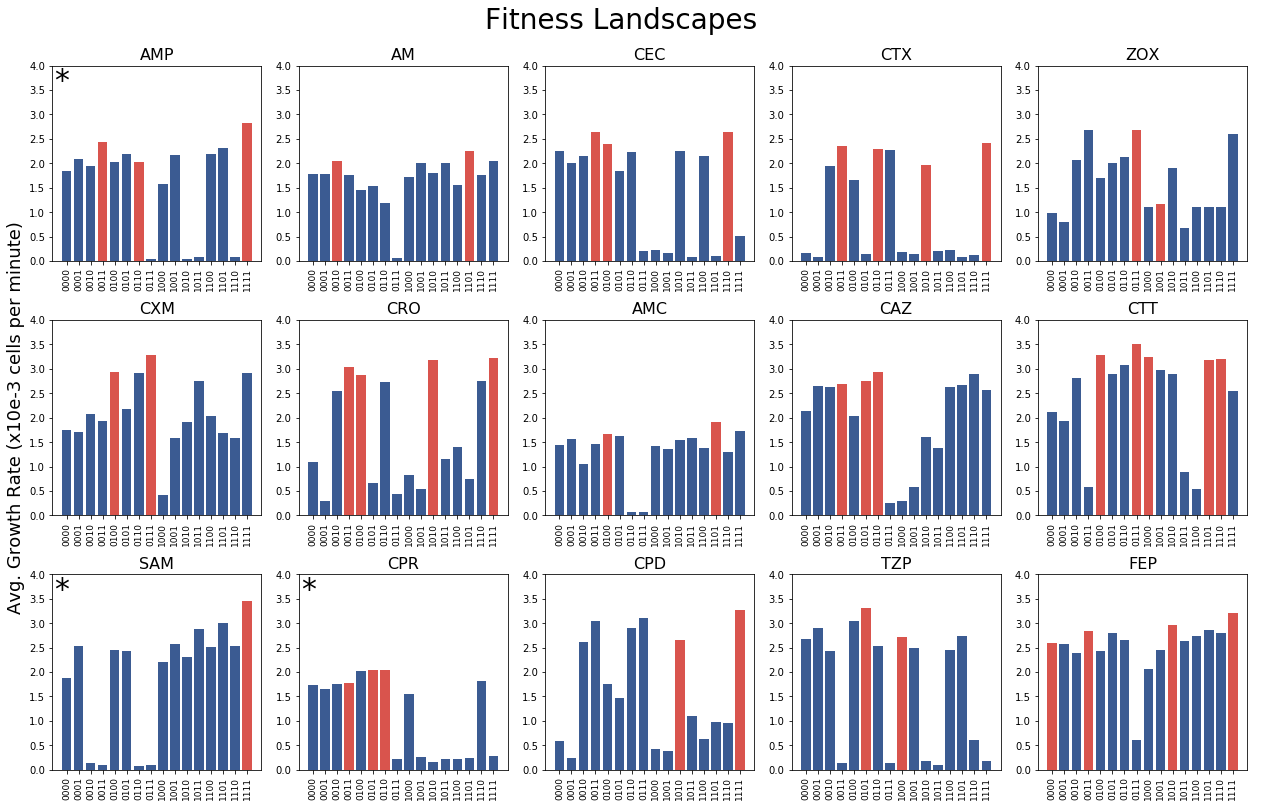

In [20]:
#==============================================================================#
# Figure 3.3
#==============================================================================#
def lab(k):
    gt = convertIntToGenotype(k, 4)
    l = "".join(map(str,gt))
    return l

def col(ls, k):
    r = sns.xkcd_rgb['pale red']
    b = sns.xkcd_rgb['denim blue']
    if ls.isPeak(convertIntToGenotype(k, 4)):
        return sns.xkcd_rgb['pale red']
    else:
        return sns.xkcd_rgb['denim blue']

fig = plt.figure(figsize=(18,12))
for k, ls in enumerate(landscapes):
    plt.subplot(3,5,k+1)
    cols = map(lambda k : col(ls, k), range(2**4))
    barlist = plt.bar(range(2**4), ls.landscape, color=cols)
    plt.ylim(0.0,3.0)
    plt.title(labs[k], size=16)
    if labs[k] in ['AMP', 'SAM', 'CPR']:
        plt.text(-1,3.5,'*',size=30)
    plt.xticks(range(2**4), map(lab, range(2**4)), size=9, rotation='vertical')
    plt.yticks(np.arange(0.0,4.1 ,0.5))

plt.subplots_adjust(hspace=0.6)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel("Avg. Growth Rate (x10e-3 cells per minute)", size=18)
plt.suptitle("Fitness Landscapes", size=28)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The following code produces scatter plots showing the pairwise fitness between the different landscapes, along with the correlation coefficient. This generates Figure 3.5 as well as the supplementary figures provided in Appendix A.

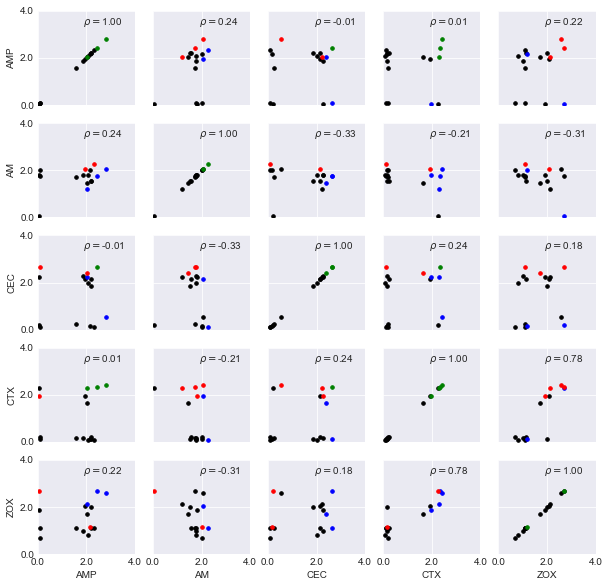

In [21]:
#==============================================================================#
# Figure 3.5
#==============================================================================#
def scatter_fitness(l1,l2):
    xsnp,ysnp = [],[] #neither a peak in l1 or l2
    xsxp,ysxp = [],[] #peak in l1, not in l2
    xsyp,ysyp = [],[] #peak in l2, not in l1
    xsbp,ysbp = [],[] #peak in l1 & l2
    for g in map(lambda x : convertIntToGenotype(x,4), range(16)):
        if l1.isPeak(g):
            if l2.isPeak(g):
                xsbp.append(l1.getFitness(g))
                ysbp.append(l2.getFitness(g))
            else:
                xsxp.append(l1.getFitness(g))
                ysxp.append(l2.getFitness(g))

        else:
            if l2.isPeak(g):
                xsyp.append(l1.getFitness(g))
                ysyp.append(l2.getFitness(g))
            else:
                xsnp.append(l1.getFitness(g))
                ysnp.append(l2.getFitness(g))

    return xsnp, ysnp, xsxp, ysxp, xsyp, ysyp, xsbp, ysbp

def scatter_plot(ax, xl, yl, fontsize=12):
    import matplotlib.ticker as ticker
    from scipy.stats import spearmanr
    xsnp,ysnp,xsxp,ysxp,xsyp,ysyp,xsbp,ysbp = scatter_fitness(landscapes[xl],
                                                             landscapes[yl])

    fullxs = xsnp + xsxp + xsyp + xsbp
    fullys = ysnp + ysxp + ysyp + ysbp

    #scatter plot
    ax.scatter(xsnp,ysnp, s=50, marker=".", c='k')
    ax.scatter(xsxp,ysxp, s=50, marker=".", c='b')
    ax.scatter(xsyp,ysyp, s=50, marker=".", c='r')
    ax.scatter(xsbp,ysbp, s=50, marker=".", c='g')

    #axis ticks
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_xlim((0.0,4.0))
    ax.set_ylim((0.0,4.0))
    ax.xaxis.set_ticks(np.arange(0.0, 4.5, 2.0))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax.yaxis.set_ticks(np.arange(0.0, 4.5, 2.0))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    #axis labels
    ax.set_xlabel(labs[xl])
    ax.set_ylabel(labs[yl])


    #Adding the spearman r
    rho = spearmanr(fullxs, fullys)[0]
    ax.annotate(r'$\rho =$'+"{:.2f}".format(rho), xy=(1.0, 1.0), 
        xytext=(.47, .85), textcoords='axes fraction', zorder=100)

width, height=5, 5
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
fig = plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

grid = Grid(fig, rect=111, nrows_ncols=(width,height), axes_pad=0.25, label_mode='L')
i,j = 0,0 #Change these values to generate figures A1-A8
for ax in grid:
    scatter_plot(ax,i,j)
    ax.title.set_visible(False)
    i+=1
    if i == width:
        i = 0
        j+=1

## Collateral Sensitivity

The following code generates the results and figures outlined in Section 3.3. In our exploration of collateral sensitivity, we assume that the initial population is a "wild-type" population, mirroring experimental evolution of drug resistance. As such, we specify an initial population as follows

In [22]:
# g=0000 is the initial genotype 
init_wt = np.array([1.]+[0. for i in range(15)])

To determine the collateral response under a second drug $y$, first we randomly select a fitness peak genotype ($g_x^*$) in the first landscape, $x$, arising from evolution from the initial genotype $g_0$. Next, the collateral response is calculated as

$\text{Collateral response of $Y$ to $X$} = \log_2\left( \frac{f_y(g_x^*)}{f_y(g_0)} \right)$

In [23]:
#==============================================================================#
# Simulates a single instance of determining collateral sensitivity
#
# As evolution is not necessarily repeatable, this is not guaranteed to generate
# the same matrix of collateral sensitivity on each instance.
#==============================================================================#
def col_sensitivity(d1, d2, init_pop, relative=True):
    limit_d1 = limit_matrices[d1]
    pop_dist = init_pop * limit_d1
    pop_dist = np.array(pop_dist)[0]
    peak = np.random.choice(np.array([i for i in range(16)]), p=pop_dist)
    if relative:
        col_sens = np.log2(landscapes[d2].getFitness(convertIntToGenotype(peak,4)) \
                           / landscapes[d2].getFitness(convertIntToGenotype(0,4)))
    else:
        col_sens = landscapes[d2].getFitness(convertIntToGenotype(peak,4)) \
                   / landscapes[d2].getFitness(convertIntToGenotype(0,4))

    return col_sens

def generateCSN(init_pop):
    network = [[col_sensitivity(d1,d2,init_pop) for d1 in range(len(landscapes))] 
               for d2 in range(len(landscapes))]
    return network


In [24]:
#==============================================================================#
# Plotting functions used to display a table of collateral response
#==============================================================================#
# Displays the matrix/heatmap
def show_CSN(network):
    fig = plt.figure(figsize=(5.3,4.5))
    ax = fig.add_subplot(111)
    cax=ax.matshow(network, cmap = plt.cm.RdBu_r, vmin = -5, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.ax.set_yticklabels(['32x','16x','8x','4x','2x','1x',
                             '2x','4x','8x','16x','32x'])
    cbar.set_label('Change From Wild-Type Sensitivity')

    ax.set_xticks(range(len(labs)))
    ax.set_yticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=45)
    ax.set_yticklabels(labs)
    ax.axis('image')

    ax.set_xlabel('First Drug')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Second Drug')

    plt.show()

# Displays a bar chart of showing number of CS/CR drug pairs
def bar_comparison(network):
    bets, wors = [],[]
    for d2 in range(len(landscapes)):
        row = np.array(network)[d2]
        bets.append(sum(map(lambda x : x<0.0, row)))
        wors.append(sum(map(lambda x : x>0.0, row)))

    bets = map(lambda x : -x, bets)
    cmap = plt.cm.RdBu

    res_bar_col = cmap(0.1)
    sen_bar_col = cmap(0.9)

    fig, ax = plt.subplots(figsize=(5,5))
    ax = plt.subplot(1,2,1)
    rects1 = ax.barh(np.arange(len(landscapes)), wors, color=res_bar_col)
    rects2 = ax.barh(np.arange(len(landscapes)), bets, color=sen_bar_col)
    plt.xlim(-15,15)
    plt.ylim(-1,15)
    ax.set_xticklabels([15,10,5,0,5,10,15])
    plt.xlabel('Number of Second Drugs')
    plt.ylabel('First Drug')
    plt.yticks(np.arange(0.0,len(landscapes)+0.0,1.0), labs)
    plt.gca().invert_yaxis()
    plt.title('Collaterally Sensitive/Resistant')

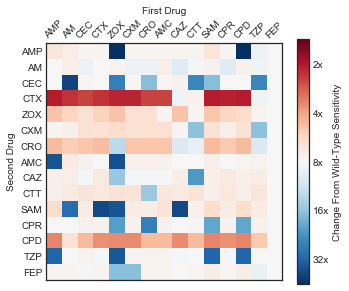

In [26]:
#==============================================================================#
# Example use.
#==============================================================================#
sns.set_style('white')
plt.figure(figsize=(5,5))
example_csn = generateCSN(init_wt)
show_CSN(example_csn)
# bar_comparison(example_csn) #Make the bar chart...

### Exploring the space of collateral sensitivity tables
The following methods are used to explore the space of collateral sensitivity tables to find the most likely outcome along with the best-case, worst-case and average-case outcome for a table of collateral sensitivity determined from a single round of experimental evolution.

In [29]:
#==============================================================================#
# Determines the most likely CSM and the associated probability
#==============================================================================#
def most_likely(init_pop):
    gs,ps = [],[]
    for d in range(15):
        limit = limit_matrices[d]
        pop_dist = np.array(init_pop * limit)[0]
        g = np.argmax(pop_dist)
        gs.append(g)
        ps.append(pop_dist[g])

    network = [[np.log2(landscapes[d2].getFitness(convertIntToGenotype(g,4)) \
                        /landscapes[d2].getFitness(convertIntToGenotype(0,4))) \
                for g in gs] \
                for d2 in range(15)]
    p = np.product(ps)
    return p,network

#==============================================================================#
# Determines the (almost certain) best and worst case outcome by means of multiple
# trials.
#==============================================================================#
def best_and_worst(trials, init_pop):
    networks = []
    for t in range(trials):
        network =  np.array(generateCSN(init_pop))
        networks.append(network)

    mins,maxs = networks[0], networks[0]
    for net in networks[1:]:
        mins = np.minimum(mins,net)
        maxs = np.maximum(maxs,net)
    return mins,maxs

#==============================================================================#
# Determines the average collateral response for each drug pair
#==============================================================================#
def expected_network(init_pop):
    
    def expected_sensitivity(d1,d2,init_pop):
        limit_d1 = limit_matrices[d1]
        pop_dist = init_pop * limit_d1
        pop_dist = np.array(pop_dist)[0]
        expected_fitness = np.log2(sum([pop_dist[i] * \
                                   landscapes[d2].getFitness(convertIntToGenotype(i,4)) \
                                   for i in range(16)])
         / landscapes[d2].getFitness(convertIntToGenotype(0,4)))
        return expected_fitness
    
    network =[[expected_sensitivity(d1,d2,init_pop) \
               for d1 in range(len(landscapes))] \
            for d2 in range(len(landscapes))]
    return network

In [30]:
#==============================================================================#
# Example use, generating Figure 3.7
#==============================================================================#
exp  = expected_network(init_wt)
best, worst = best_and_worst(1000, init_wt)
p,net = most_likely(init_wt)
print "The most likely CSM occurs with probability: ", p

# # Uncomment all of the following generate Figure 3.7 (in parts):
# show_CSN(exp)
# bar_comparison(exp)
# show_CSN(best)
# bar_comparison(best)
# show_CSN(worst)
# bar_comparison(worst)
# show_CSN(net)
# bar_comparison(net)

The most likely CSM occurs with probability:  0.00229219059595


### Simulating experimental evolution to find CS drugs
In the thesis (Section 3.3.1), we asked the following two questions:
1. What is the probability that a randomly chosen the drug pair exhibits cross resistance?   
2. Given that a drug pair exhibits collateral sensitivity in a single simulation of experimental evolution, what is it the likelihood that it exhibits cross resistance in second such experiment?

The following functions determine the answers to these questions.

In [31]:
#==============================================================================#
# Computes the likelihood of CLR from a random drug pair
#
# Here we assume that the drug pair is chosen uniformly at random. As such, 
# the probability of choosing a CR pair at random can be determined analytically by 
# summing, over all possible pairs, the total probability mass of collateral
# resistance and then normalising appropriately.
#==============================================================================#
def random_cl():
    tot = 0.
    for d1 in range(15):
        for d2 in range(15):
            if d1!=d2:
                temp = 0
                wt_f = landscapes[d1].getFitness([0,0,0,0])
                ev_pop = init_wt * limit_matrices[d1]
                ev_pop = np.array(ev_pop)[0]
                for k in range(len(ev_pop)):
                    ev_f = landscapes[d2].getFitness(convertIntToGenotype(k,4))
                    if ev_f > wt_f:
                        temp+=ev_pop[k]
                tot+=temp
    tot = tot / (15. * 14.)
    return tot

#==============================================================================#
# Determines the probability that a pair identified as CS in a single simulation of 
# experimental evolution is CR in a second simulation.
#
# This is determined by repeatedly sampling a random matrix of collateral response,
# choosing a CS pair at random and then determining the likelihood that the first of 
# that pair induces CR in the second.
#==============================================================================#
def prob_clr():
    #generate a random csn
    csn = generateCSN(init_wt)
    #Pick a pair with CS are random
    flag = True
    while flag:
        d1 = random.randint(0,14)
        d2 = random.randint(0,14)
        if csn[d1][d2] < 0.0:
            flag = False

    #find the probability of clr.
    prob_res = 0.0
    wt_f = landscapes[d1].getFitness([0,0,0,0])
    ev_pop = init_wt * limit_matrices[d1]
    ev_pop = np.array(ev_pop)[0]
    for k in range(len(ev_pop)):
        ev_f = landscapes[d2].getFitness(convertIntToGenotype(k,4))
        if ev_f > wt_f:
            prob_res += ev_pop[k]

    return prob_res

#10000 samples:
S = 10 #10000 #In the paper/thesis
cr_ps =  np.mean([prob_clr() for _ in range(S)])

print "The probability of CR in a random pair is: ", random_cl()
print "The probability of CR in a random pair identified as CS is: ", cr_ps

The probability of CR in a random pair is:  0.57671957672
The probability of CR in a random pair identified as CS is:  0.475


## Collateral Sensitivity Likelihoods
Here we derive likelihood of collateral sensitivity between pairs of drugs. This code produces the results in Section 3.3.2 of the thesis.

In [35]:
#==============================================================================#
# Given two drugs, returns the probability that evolution
# under the first results in a genotype with fitness under the
# second that is lower than the WT fitness.
#==============================================================================#
def prob_better(d1,d2,init_pop):
    limit_d1 = limit_matrices[d1]
    pop_dist = init_pop * limit_d1
    pop_dist = np.array(pop_dist)[0]

    prob = 0
    wt_f = landscapes[d2].getFitness([0,0,0,0])
    for i in range(len(pop_dist)):
        if landscapes[d2].getFitness(convertIntToGenotype(i,4)) < wt_f:
            prob+=pop_dist[i]

    return prob
#==============================================================================#
# Collateral Sensitivity Likelihood matrix
#==============================================================================#
def prob_matrix(init_pop):
    mat = [[prob_better(d1,d2,init_pop) for d1 in range(len(landscapes))] \
           for d2 in range(len(landscapes))]
    return mat

#==============================================================================#
# Displays a CSL
#==============================================================================#
def show_CSL(mat):
    fig = plt.figure(figsize  = (4,3))
    ax = fig.add_subplot(111)
    cax=ax.matshow(mat, cmap = plt.cm.Greens, vmin = 0.0, vmax = 1.0)

    #cbar = fig.colorbar(cax)
    #cbar.set_label('Probability of Collateral Sensitivity')

    ax.set_xticks(range(len(labs)))
    ax.set_yticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=45, size='14')
    ax.set_yticklabels(labs, size='14')
    ax.axis('image')

    ax.set_xlabel('First Drug Applied', size='18')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Second Drug (To Be Applied)', size='18')

#==============================================================================#
# Returns a CSL in which all entries <p are set to zero
#==============================================================================#
def cut_off_probs_CSL(network, p):
    new_net = [[x if p-x<=10**(-8) else 0.0 for x in y] for y in network]
    return new_net

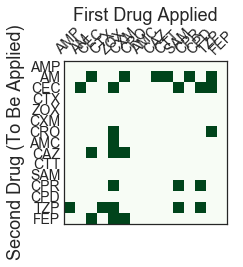

In [36]:
#==============================================================================#
# Example use. Figure 3.8 (in parts)
#==============================================================================#
sns.set_style('white')
csl = prob_matrix(init_wt)
# show_CSL(csl)  #Uncomment for other figures.
show_CSL(cut_off_probs_CSL(csl, 1.0))
# show_CSL(cut_off_probs_CSL(csl, 0.75))

## Worst Case Collateral Response 
The following code identified those drug pairs where the worst case collateral response lies below a specified threshold for fold change in drug resistance. These results are presented in Figure 3.9

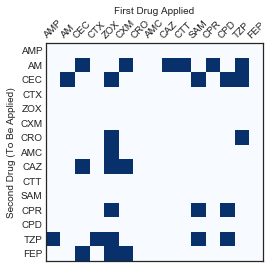

In [37]:
def thresh_network(init_pop,thresh):
    
    # Thresholded probabilistic CSNs. What is the likelihood that your fitness is below a certain threshold?
    def prob_thresh(d1,d2,init_pop, thresh):
        limit_d1 = limit_matrices[d1]
        pop_dist = init_pop * limit_d1
        pop_dist = np.array(pop_dist)[0]
        prob = 0.0

        wt_f = landscapes[d2].getFitness([0,0,0,0])

        for i in range(len(pop_dist)):
            if (landscapes[d2].getFitness(convertIntToGenotype(i,4))/wt_f)  < thresh:
                prob+=pop_dist[i]

        #return prob

        if (prob - 1.0)**2 < 10**-7:
            return 1.0
        else:
            return 0.0
    
    
    mat = [[prob_thresh(d1,d2,init_pop,thresh) for d1 in range(len(landscapes))] \
           for d2 in range(len(landscapes))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax=ax.matshow(mat, cmap = plt.cm.Blues, vmin = 0.0, vmax = 1.0)

    #cbar = fig.colorbar(cax)
    #cbar.set_label('Probability of Collateral Sensitivity')

    ax.set_xticks(range(len(labs)))
    ax.set_yticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=45)
    ax.set_yticklabels(labs)
    ax.axis('image')

    ax.set_xlabel('First Drug Applied')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Second Drug (To Be Applied)')
    plt.show()
    
#Example, pairs that guarantee CS:
thresh_network(init_wt, 1.0)

# Evolutionary Steering
Below we derive the results presenting in Section 3.4 which outline the potential for carefully chosen drug sequences to minimise the likelihood of highly resistant disease. Here, we assume that the initial genotype for the disease population is unknown, as such we set:

In [420]:
# Each genotype is equally likely to be the initial genotype
init_pop = np.array([1./2**4 for i in range(16)])

The following code produces the results presented in Table 3.3, indicating the best sequence of 1, 2 or 3 drugs to steer evolution to __avoid highly resistant__ genotypes.

In [39]:
#==============================================================================#
# The best steering combinations are determined by an exhaustive search of all
# sequences of 1, 2 or 3 drugs. 
#==============================================================================#

#==============================================================================#
# Determines for each drug the probability of ending at the highest fitness peak
# genotype when starting from the initial distribution init_pop.
#==============================================================================#
def probHighestPeak(init_pop):
    highest_pgs_probs = []
    for t in range(len(limit_matrices)):
        dist = np.array(init_pop * limit_matrices[t])[0]
        global_peak_index = convertGenotypeToInt(landscapes[t].getGlobalPeak())
        highest_pgs_probs.append(dist[global_peak_index])
        print landscapes[t].name+":", highest_pgs_probs[t]

    return highest_pgs_probs
#==============================================================================#
# Determines for each drug the single steering drug which minimizes the 
# probability that evolution proceeds to the highest fitness peak.
#==============================================================================#
def highPeakBestSingle(init_pop):
    best_steerers = []
    for t in range(len(limit_matrices)):
        global_peak_index = convertGenotypeToInt(landscapes[t].getGlobalPeak())
        best_prob = 1.0
        best_steerer = -1
        for s in range(len(limit_matrices)):
            dist = np.array(init_pop * limit_matrices[s] * limit_matrices[t])[0]
            if dist[global_peak_index] < best_prob:
                best_prob = dist[global_peak_index]
                best_steerer = s
        best_steerers.append((landscapes[s], best_prob))

        print landscapes[t].name+":", landscapes[best_steerer].name, best_prob
    return best_steerers

#==============================================================================#
# Determines for each drug the ordered pair of steering drugs which minimizes 
# the probability that evolution proceeds to the highest fitness peak.
#==============================================================================#
def highPeakBestDouble(init_pop):
    best_steerers = []
    for t in range(len(limit_matrices)):
        global_peak_index = convertGenotypeToInt(landscapes[t].getGlobalPeak())
        best_prob = 1.0
        best_s1 = -1
        best_s2 = -1
        for s1 in range(len(limit_matrices)):
            for s2 in range(len(limit_matrices)):
                dist = np.array(init_pop * limit_matrices[s1] * \
                                limit_matrices[s2] * limit_matrices[t])[0]
                if dist[global_peak_index] < best_prob:
                    best_prob = dist[global_peak_index]
                    best_s1 = s1
                    best_s2 = s2

        print landscapes[t].name+":", landscapes[best_s1].name+\
              " ---> "+landscapes[best_s2].name+", ", best_prob
        best_steerers.append((landscapes[best_s2], landscapes[best_s2], best_prob))
    return best_steerers

#==============================================================================#
# Determines for each drug the ordered triple of steering drugs which minimizes 
# the probability that evolution proceeds to the highest fitness peak.
#==============================================================================#
def highPeakBestTriple(init_pop):
    best_steerers = []
    for t in range(len(limit_matrices)):
        global_peak_index = convertGenotypeToInt(landscapes[t].getGlobalPeak())
        best_prob = 1.0
        best_s1 = -1
        best_s2 = -1
        best_s3 = -1
        for s1 in range(len(limit_matrices)):
            for s2 in range(len(limit_matrices)):
                for s3 in range(len(limit_matrices)):
                    dist = np.array(init_pop * limit_matrices[s1] * limit_matrices[s2] * 
                                    limit_matrices[s3] * limit_matrices[t])[0]
                    if dist[global_peak_index] < best_prob:
                        best_prob = dist[global_peak_index]
                        best_s1 = s1
                        best_s2 = s2
                        best_s3 = s3


        print landscapes[t].name+":", landscapes[best_s1].name+" ---> "+ \
              landscapes[best_s2].name+" ---> "+landscapes[best_s3].name\
              +", ", best_prob
        best_steerers.append((landscapes[best_s1], landscapes[best_s2], 
                              landscapes[best_s3], best_prob))

    return best_steerers

In [428]:
%%capture
#Delete above line to print results
#==============================================================================#
# Results (Table 3.3)
#==============================================================================#
print "Results"
print "Final Drug: Steering combo (P(highest peak))"
print
best_singles = highPeakBestSingle(init_pop)
print
best_doubles = highPeakBestDouble(init_pop)
print
best_triple = highPeakBestTriple(init_pop)

The following code produces the results presented in Table 3.4, indicating the best sequence of 1, 2 or 3 drugs to steer evolution to maximise the likelihood of finding the least resistant genotype.

In [41]:
#==============================================================================#
# The best steering combinations are determined by an exhaustive search of all
# sequences of 1, 2 or 3 drugs. 
#==============================================================================#

#==============================================================================#
# Determines for each drug the probability of ending at the lowest fitness peak
# genotype when starting from the initial distribution init_pop.
#==============================================================================#
def probLowestPeak(init_pop):
    lowest_pgs_probs = []
    for t in range(len(limit_matrices)):
        dist = np.array(init_pop * limit_matrices[t])[0]
        lpg = landscapes[t].getLowestFitnessPeak()
        lowest_pgs_probs.append(dist[convertGenotypeToInt(lpg)])
        print landscapes[t].name+":", lowest_pgs_probs[t]

    return lowest_pgs_probs

#==============================================================================#
# Determines for each drug the single steering drug which maximizes the probability
# that evolution proceeds to the lowest fitness peak.
#==============================================================================#
def lowestPeakBestSingle(init_pop):
    best_steerers = [] 
    for t in range(len(limit_matrices)):
        lowest_peak_index = convertGenotypeToInt(\
                            landscapes[t].getLowestFitnessPeak())

        best_steerer = -1
        best_prob = 0.0

        #For each possible steerer
        for s in range(len(limit_matrices)):
            dist = np.array(init_pop * limit_matrices[s] * limit_matrices[t])[0]
            if dist[lowest_peak_index] > best_prob:
                best_prob = dist[lowest_peak_index]
                best_steerer = s
        best_steerers.append((landscapes[best_steerer], best_prob))

        print landscapes[t].name+":", best_steerers[t][0].name, best_steerers[t][1]

    return best_steerers

#==============================================================================#
# Determines for each drug the ordered pair of steering drugs which maximizes 
# the probability that evolution proceeds to the lowest fitness peak.
#==============================================================================#
def lowestPeakBestDouble(init_pop):
    best_steerers = [] 
    for t in range(len(limit_matrices)):
        lowest_peak_index = convertGenotypeToInt(\
                            landscapes[t].getLowestFitnessPeak())

        best_s1 = -1
        best_s2 = -1
        best_prob = 0.0
        for s1 in range(len(limit_matrices)):
            for s2 in range(len(limit_matrices)):
                dist = np.array(init_pop * limit_matrices[s1] * \
                                limit_matrices[s2] * limit_matrices[t])[0]
                if dist[lowest_peak_index] > best_prob:
                    best_prob = dist[lowest_peak_index]
                    best_s1 = s1
                    best_s2 = s2
        best_steerers.append((landscapes[best_s1], landscapes[best_s2], best_prob))
        print landscapes[t].name+":  ", landscapes[best_s1].name+" ---> "+ \
              landscapes[best_s2].name+", ", best_prob

    return best_steerers

#==============================================================================#
# Determines for each drug the ordered triple of steering drugs which maximizes 
# the probability that evolution proceeds to the lowest fitness peak.
#==============================================================================#
def lowestPeakBestTriple(init_pop):
    best_steerers = []
    for t in range(len(limit_matrices)):
        lowest_peak_index = convertGenotypeToInt(\
                            landscapes[t].getLowestFitnessPeak())

        best_s1 = -1
        best_s2 = -1
        best_s3 = -1
        best_prob = 0.0
        for s1 in range(len(limit_matrices)):
            for s2 in range(len(limit_matrices)):
                for s3 in range(len(limit_matrices)):
                    dist = np.array(init_pop * limit_matrices[s1] 
                                    * limit_matrices[s2] * limit_matrices[s3] *
                                    limit_matrices[t])[0]
                    if dist[lowest_peak_index] > best_prob:
                        best_prob = dist[lowest_peak_index]
                        best_s1 = s1
                        best_s2 = s2
                        best_s3 = s3
        best_steerers.append((landscapes[best_s1], landscapes[best_s2],\
                              landscapes[best_s3], best_prob))
        print landscapes[t].name+":  ", landscapes[best_s1].name+" ---> "+ \
              landscapes[best_s2].name+" ---> "+landscapes[best_s3].name+ \
              ", ", best_prob

    return best_steerers

In [430]:
%%capture
#Delete above line to print results
#==============================================================================#
# Results (Table 3.4)
#==============================================================================#
print "Results"
print "Final Drug: Steering combo (P(lowest peak))"
print
best_singles = lowestPeakBestSingle(init_pop)
print
best_doubles = lowestPeakBestDouble(init_pop)
print
best_triple = lowestPeakBestTriple(init_pop)

The following produces the results of Table 3.5, wherein all possible steering sequences of length 1, 2 and 3 are considered to determined the efficacy (or dangers) of __random drug ordering__.

In [44]:
#==============================================================================#
# Exhaustive exploration of all drug sequences of length 1,2 or 3.
#==============================================================================#

#==============================================================================#
# Determines the percentage of single steering drugs that decrease 
# and increase the probability of evolution to the highest peak of the landscape.
#==============================================================================#
def singleSteererPercentages(init_pop, allowSAM = True):

    steering_stats = []

    overall_better = 0
    overall_worse = 0
    overall_same = 0

    for t in range(len(limit_matrices)):
        if t!=10 or allowSAM:

            better = 0
            worse = 0
            same = 0

            peak_genotype = landscapes[t].getGlobalPeak()
            peak_genotype_index = convertGenotypeToInt(peak_genotype)
            peak_fitness = landscapes[t].getFitness(peak_genotype)

            for s in range(len(limit_matrices)): 
                steered_pop = (init_pop * limit_matrices[s] * 
                               limit_matrices[t]).tolist()[0]
                straight_pop = (init_pop * limit_matrices[t]).tolist()[0]

                if np.abs(steered_pop[peak_genotype_index] - \
                          straight_pop[peak_genotype_index]) < 10**-15:
                    
                    same+=1
                    
                elif steered_pop[peak_genotype_index] > \
                     straight_pop[peak_genotype_index]:
                        
                    worse+=1
                    
                elif steered_pop[peak_genotype_index] < \
                     straight_pop[peak_genotype_index]:
                        
                    better+=1

            steering_stats.append((better,worse,same))


            pc_better = 100*float(better) / (better+worse+same)
            pc_worse  = 100*float(worse) / (better+worse+same)
            print landscapes[t].name+", better:", str(better)+ \
            " ("+str(pc_better)+"%)", ", worse:", str(worse)+" ("+str(pc_worse)+"%)"

            overall_better+=better
            overall_worse+=worse
            overall_same+=same
            pc_ov_better = 100*float(overall_better) / \
                           (overall_better+overall_worse+overall_same)
            pc_ov_worse = 100*float(overall_worse) / \
                          (overall_better+overall_worse+overall_same)



    print "Overall, better:", str(overall_better)+\
          " ("+str(pc_ov_better)+"%)", ", worse:", str(overall_worse)+\
          " ("+str(pc_ov_worse)+"%)"
    return steering_stats

#==============================================================================#
# Determines the percentage of ordered pairs of steering drugs that decrease 
# and increase the probability of evolution to the highest peak of the landscape.
#==============================================================================#
def doubleSteererPercentages(init_pop, allowSAM = True):
    steering_stats = []

    overall_better = 0
    overall_worse = 0
    overall_same = 0

    for t in range(len(limit_matrices)):
        if t!=10 or allowSAM:

            better = 0
            worse = 0
            same = 0

            peak_genotype = landscapes[t].getGlobalPeak()
            peak_genotype_index = convertGenotypeToInt(peak_genotype)
            peak_fitness = landscapes[t].getFitness(peak_genotype)

            for k1 in range(len(limit_matrices)):
                for k2 in range(len(limit_matrices)): 
                    steered_pop = (init_pop * limit_matrices[k1] * 
                                   limit_matrices[k2] * 
                                   limit_matrices[t]).tolist()[0]
                    straight_pop = (init_pop * limit_matrices[t]).tolist()[0]


                    if np.abs(steered_pop[peak_genotype_index] -\
                              straight_pop[peak_genotype_index]) < 10**-15:
                        
                        same+=1
                        
                    elif steered_pop[peak_genotype_index] >\
                         straight_pop[peak_genotype_index]:
                            
                        worse+=1
                        
                    elif steered_pop[peak_genotype_index] <\
                         straight_pop[peak_genotype_index]:
                            
                        better+=1

            steering_stats.append((better,worse,same))


            pc_better = 100*float(better) / (better+worse+same)
            pc_worse  = 100*float(worse) / (better+worse+same)
            print landscapes[t].name+", better:", str(better)+ \
                  " ("+str(pc_better)+"%)", ", worse:", str(worse)+\
                  " ("+str(pc_worse)+"%)"

            overall_better+=better
            overall_worse+=worse
            overall_same+=same
            pc_ov_better = 100*float(overall_better) / \
                           (overall_better+overall_worse+overall_same)
            pc_ov_worse = 100*float(overall_worse) / \
                          (overall_better+overall_worse+overall_same)



    print "Overall, better:", str(overall_better)+\
          " ("+str(pc_ov_better)+"%)", ", worse:", str(overall_worse)+\
          " ("+str(pc_ov_worse)+"%)"
    return steering_stats


#==============================================================================#
# Determines the percentage of ordered triples of steering drugs that decrease 
# and increase the probability of evolution to the highest peak of the landscape.
#==============================================================================#
def tripleSteererPercentages(init_pop, allowSAM = True):
    steering_stats = []

    overall_better = 0
    overall_worse = 0
    overall_same = 0

    for t in range(len(limit_matrices)):
        if t!=10 or allowSAM:

            better = 0
            worse = 0
            same = 0

            peak_genotype = landscapes[t].getGlobalPeak()
            peak_genotype_index = convertGenotypeToInt(peak_genotype)
            peak_fitness = landscapes[t].getFitness(peak_genotype)

            for k1 in range(len(limit_matrices)):
                for k2 in range(len(limit_matrices)): 
                    for k3 in range(len(limit_matrices)):

                        steered_pop = (init_pop * limit_matrices[k1] * 
                                       limit_matrices[k2] * 
                                       limit_matrices[k3] * 
                                       limit_matrices[t]).tolist()[0]
                        straight_pop = (init_pop * limit_matrices[t]).tolist()[0]

                        if np.abs(steered_pop[peak_genotype_index] -\
                                  straight_pop[peak_genotype_index])<10**-15:
                            
                            same+=1
                            
                        elif steered_pop[peak_genotype_index] >\
                             straight_pop[peak_genotype_index]:
                                
                            worse+=1
                            
                        elif steered_pop[peak_genotype_index] <\
                             straight_pop[peak_genotype_index]:
                                
                            better+=1

            steering_stats.append((better,worse,same))


            pc_better = 100*float(better) / (better+worse+same)
            pc_worse  = 100*float(worse) / (better+worse+same)
            print landscapes[t].name+", better:", str(better)+\
                  " ("+str(pc_better)+"%)", ", worse:", str(worse)+\
                  " ("+str(pc_worse)+"%)"

            overall_better+=better
            overall_worse+=worse
            overall_same+=same
            pc_ov_better = 100*float(overall_better) / \
            (overall_better+overall_worse+overall_same)
            pc_ov_worse = 100*float(overall_worse) / \
            (overall_better+overall_worse+overall_same)



    print "Overall, better:", str(overall_better)+\
          " ("+str(pc_ov_better)+"%)", ", worse:", str(overall_worse)+\
          " ("+str(pc_ov_worse)+"%)"
    return steering_stats

In [432]:
%%capture
#Delete above line to print results
#==============================================================================#
# Results (Table 3.5)
#==============================================================================#
print "Results"
print
print "Singles"
singleSteererPercentages(init_pop)
print 
print "Doubles"
doubleSteererPercentages(init_pop)
print
print "Triples"
tripleSteererPercentages(init_pop);

## Accounting for Variance in Fitness Measurements
Typically, measurements of growth rate (which is used as a proxy for fitness here) are subject to substantial variance owing both to intrinsic biological noise and extrinsic experimental noise introduced between replicates. Unfortunately, despite reporting fitness values as the average of 12 replicates, neither the raw values nor measurements of variance are reported by Mira et al.

Here, we test the sensitivity of our results to variance in the values that comprise the fitness values. We begin by implementing a function that resamples all of the fitness values uniformly from an interval around the reported mean.

In [433]:
def resample(landscape, variance=0.3):
    vals = landscape.landscape
    fl = FitnessLandscape(map(lambda x : np.random.uniform((1-variance)*x,
                                                           (1+variance)*x),vals),
                          name=landscape.name)
    return fl

Central to our results on evolutionary steering and the non-repeatability is the existence of multi-peaked landscapes, we begin by exploring how the number of peaks varies in each landscape under resampling of the fitness values.

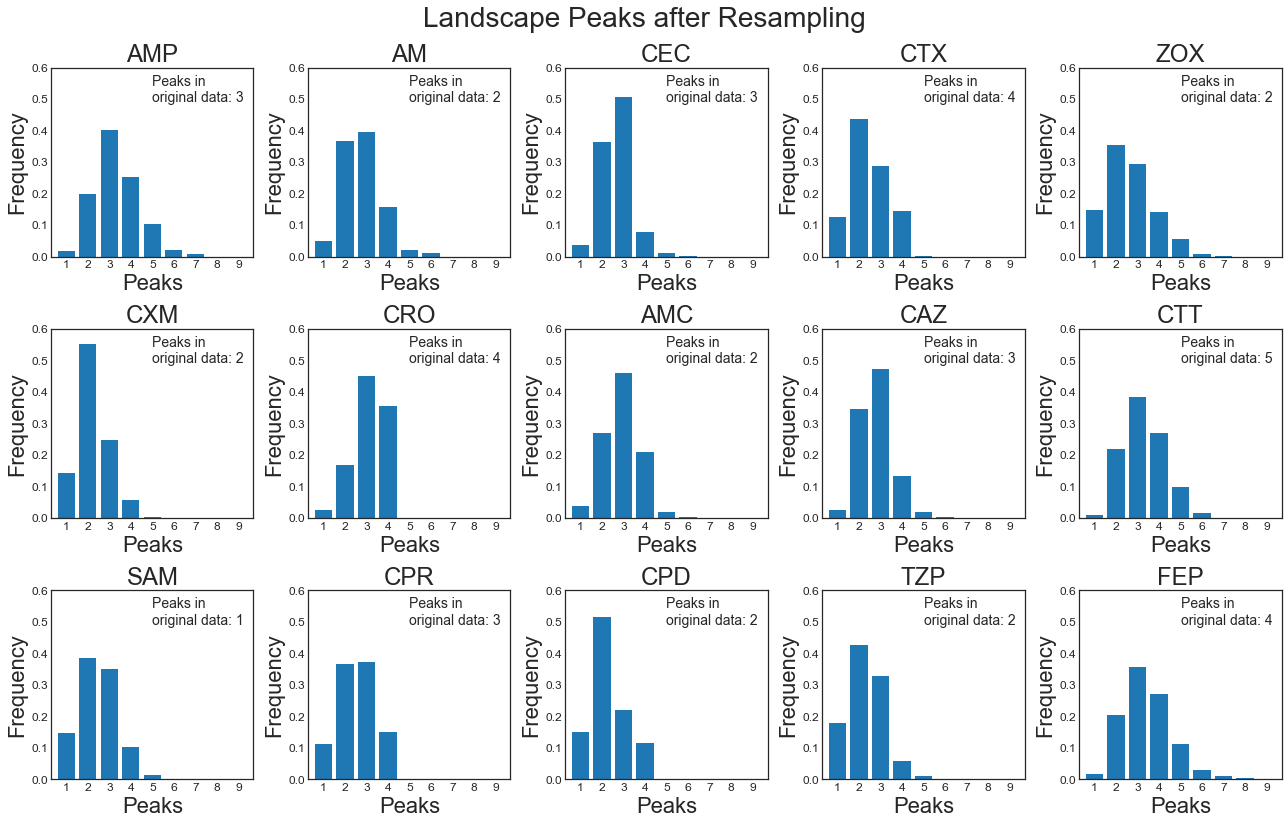

In [436]:
S=10 #1000 #in the paper/thesis
fig = plt.figure(figsize=(18,12))
for k, ls in enumerate(landscapes):
    plt.subplot(3,5,k+1)
    samples=S
    peaks = []
    landscape=landscapes[k]
    mean_peaks = len(landscape.getPeaks())
    for _ in range(samples):
        fl = resample(landscape)
        peaks.append(len(fl.getPeaks()))
    
    plt.hist(peaks, bins=np.arange(0,10.5,1.0), width=0.8, normed=True)
    plt.yticks(size=12)
    plt.xticks(np.arange(0.4,10.3,1.0), np.arange(0,10,1), size=12)
    plt.ylabel('Frequency', size=22)
    plt.xlabel('Peaks', size=22)
    plt.title(labs[k], size=24)
    plt.xlim(0.7,10.1)
    plt.ylim(0.0,0.6)
    plt.annotate("Peaks in \noriginal data: " + str(mean_peaks), xy=(8, 0.4), 
        xytext=(0.5, .82), textcoords='axes fraction', zorder=100, size=14)
plt.suptitle('Landscape Peaks after Resampling', size=28)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Collateral Sensitivity and Variance
Central to our results regarding collateral sensitivity is the phenomenon whereby a drug pair reported as collaterally sensitive from a single replicate of experimental evolution can indeed exhibit cross resistance. Here, we validate the robustness of this result to variance in the derived fitness landscape.

We assume that the variance in fitness values is biologically intrinsic, such that two separate biological replicates will occur with slightly different fitness landscapes (determined by resampling the landscape each time). We begin by computing the likelihood of cross-resistance under these assumptions

In [121]:
#==============================================================================#
# Computes the likelihood of CR from a random drug pair where the landscape is
# resampled each time. This calculation works as follows:
# Repeat S times:
#    1. Sample a drug pair at random.
#    2. Resample the landscapes from these two drugs
#    3. Compute the likelihood of cross-resistance
# Then:
#    Average over the CR likelihoods.
#==============================================================================#
def resampled_CR_prob(S):
    tot = 0.
    for _ in range(S):
        d1, d2 = np.random.choice(range(15), 2, replace=False)
        l1 = resample(landscapes[d1])
        l2 = resample(landscapes[d2])

        limit1 = limitMatrix(buildTransitionMatrix(l1))

        wt_f = l1.getFitness([0,0,0,0])
        ev_pop = init_wt * limit1
        ev_pop = np.array(ev_pop)[0]
        temp=0.
        for k in range(len(ev_pop)):
            ev_f = l2.getFitness(convertIntToGenotype(k,4))
            if ev_f > wt_f:
                temp+=ev_pop[k]
        tot+=temp

    return tot/S

#==============================================================================#
# Computes the likelihood of CR for a pair of drugs reported as CS in a previous
# evolutionary replicate. This value is calculated as follows:
# Repeat S times:
#   1. Resample all landscapes, build a table of collateral response
#   2. Choose uniformly at random a drug pair from the table which exhibits CS
#   3. Resample the landscape for both drugs
#   4. Compute the likelihood of CR in thew new landscapes
# Then:
#   Average over the CR likelihoods
#==============================================================================#

#==============================================================================#
# Simulates a single instance of determining collateral sensitivity
# with resampled landscapes.
#==============================================================================#
def resampled_col_sensitivity(d1, d2, init_pop, relative=True):
    limit_d1 = limitMatrix(buildTransitionMatrix(resample(landscapes[d1])))
    pop_dist = init_pop * limit_d1
    pop_dist = np.array(pop_dist)[0]
    peak = np.random.choice(np.array([i for i in range(16)]), p=pop_dist)
    
    landscape2 = resample(landscapes[d2])
    
    col_sens = np.log2(landscape2.getFitness(convertIntToGenotype(peak,4)) \
                       / landscape2.getFitness(convertIntToGenotype(0,4)))
    return col_sens

def resampled_generateCSN(init_pop):
    network = [[resampled_col_sensitivity(d1,d2,init_pop)\
                for d1 in range(len(landscapes))] 
               for d2 in range(len(landscapes))]
    return network

#==============================================================================#
# Calculates the likelihood of CR following a positive CS hit.
#==============================================================================#
def resampled_CSCR_likelihoods(S):
    pr = 0.0
    for _ in range(S):
        #generate a random csn
        csn = resampled_generateCSN(init_wt)
        #Pick a pair with CS are random
        flag = True
        while flag:
            d1 = random.randint(0,14)
            d2 = random.randint(0,14)
            if csn[d1][d2] < 0.0:
                flag = False

        #find the probability of clr.
        prob_res = 0.0
        l1 = resample(landscapes[d1])
        l2 = resample(landscapes[d2])
        limit1 = limitMatrix(buildTransitionMatrix(l1))
        wt_f = l1.getFitness([0,0,0,0])
        ev_pop = init_wt * limit_matrices[d1]
        ev_pop = np.array(ev_pop)[0]
        for k in range(len(ev_pop)):
            ev_f = l2.getFitness(convertIntToGenotype(k,4))
            if ev_f > wt_f:
                prob_res += ev_pop[k]
                
        pr += prob_res

    return pr/S

S=10 #10000 in the thesis
print "Probability of CR", resampled_CR_prob(S) #approx 0.54
print "Probability of CR following CS", resampled_CSCR_likelihoods(S) #Approx 0.53

Probability of CR 0.538365917567
Probability of CR following CS 0.531055555556


Next we sample an extended collateral sensitivity likelihood table as follows. For each drug pair, we resample the landscapes 100 times and determine the likelihood of CS for each resampled pair. The average of these probabilities is the _extended collateral sensitivity likelihood_.

In [454]:
#==============================================================================#
# By first resampling the drug landscapes, returns the probability that evolution
# under a first results in a genotype with fitness under a
# second that is lower than the WT fitness.
#==============================================================================#
def resampled_prob_better(d1,d2,init_pop):
    l1 = resample(landscapes[d1])
    if d2!=d1: #Do not resample twice if they are the same drug
        l2 = resample(landscapes[d2])
    else:
        l2 = l1
        
    limit_d1 = limitMatrix(buildTransitionMatrix(l1))
    pop_dist = init_pop * limit_d1
    pop_dist = np.array(pop_dist)[0]
    
    prob = 0.
    wt_f = l2.getFitness([0,0,0,0])
    for i in range(len(pop_dist)):
        if l2.getFitness(convertIntToGenotype(i,4)) < wt_f:
            prob+=pop_dist[i]
    return prob

#==============================================================================#
# Extended Collateral Sensitivity Likelihood matrix
#==============================================================================#
def resampled_prob_matrix(init_pop, S=10):
    mat = [[np.mean([resampled_prob_better(d1,d2,init_pop) for _ in range(S)]) \
            for d1 in range(len(landscapes))] for d2 in range(len(landscapes))]
    return mat

S=10 #1000 #in the thesis.
e_csl  = resampled_prob_matrix(init_wt, S)

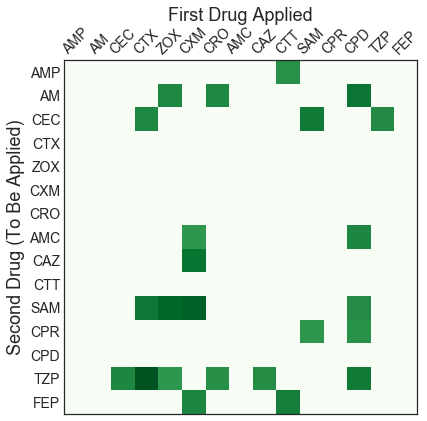

In [455]:
#Displaying the resampled CSL and a thresholded version - Uncomment for figures
# show_CSL(e_csl)
# show_CSL(cut_off_probs_CSL(e_csl, 0.9))
# show_CSL(cut_off_probs_CSL(e_csl, 0.8))
show_CSL(cut_off_probs_CSL(e_csl, 0.7))

Finally, we can explore the change in CSL value that arises from resampling by considering the difference between the two CSL matrices.

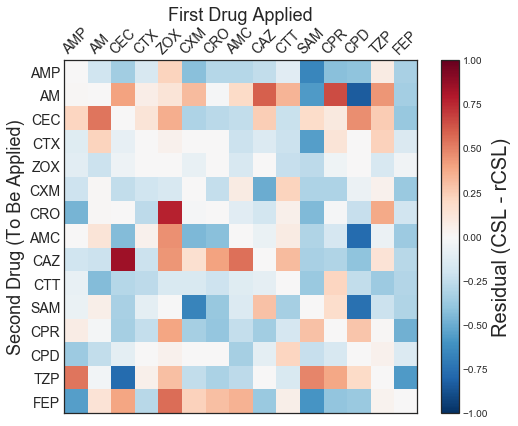

In [456]:
residuals = np.matrix(csl) - np.matrix(e_csl)
fig = plt.figure(figsize  = (8,6.5))
ax = fig.add_subplot(111)
cax=ax.matshow(residuals, cmap = 'RdBu_r', vmin = -1.0, vmax = 1.0)

cbar = fig.colorbar(cax)
cbar.set_label('Residual (CSL - rCSL)', size=20)

ax.set_xticks(range(len(labs)))
ax.set_yticks(range(len(labs)))
ax.set_xticklabels(labs, rotation=45, size='14')
ax.set_yticklabels(labs, size='14')
ax.axis('image')

ax.set_xlabel('First Drug Applied', size='18')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Second Drug (To Be Applied)', size='18');

### Steering and Variance
To conclude this analysis of the effects of fitness variance on the predictions of our steering model, we now test the efficacy of the previously derived optimal steering strategies on resampled landscapes.

In [457]:
%%capture
bests_hp = highPeakBestTriple(init_pop)
bests_lp = lowestPeakBestTriple(init_pop)

In [458]:
def resample_steered_hp(f_ix, init_pop):
    f_ls = resample(landscapes[f_ix])
    a1, a2, a3, p = bests_hp[f_ix]

    if a1.name != f_ls.name:
        a1 = resample(a1)
    else:
        a1 = f_ls

    if a2.name == a1.name:
        a2 = a1
    elif a2.name == f_ls.name:
        a2 = f_ls
    else:
        a2 = resample(a2)

    if a3.name == a2.name:
        a3 = a2
    elif a3.name == a1.name:
        a3 = a1
    elif a3.name == f_ls.name:
        a3 = f_ls
    else:
        a3 = resample(a3)

    p1 = limitMatrix(buildTransitionMatrix(a1))
    p2 = limitMatrix(buildTransitionMatrix(a2))
    p3 = limitMatrix(buildTransitionMatrix(a3))
    pf = limitMatrix(buildTransitionMatrix(f_ls)) #Final drug

    dist = np.array(init_pop * p1 * p2 * p3 * pf)[0]
    return dist[convertGenotypeToInt(f_ls.getGlobalPeak())]

# S=10000
# for ix in range(15):
#     dist = [resample_steered_hp(ix, init_pop) for _ in range(S)]
#     name = landscapes[ix].name
#     np.save('./resampled_steering/hp_'+name+'.npy', dist)


In [459]:
def resample_steered_lp(f_ix, init_pop):
    f_ls = resample(landscapes[f_ix])
    a1, a2, a3, p = bests_lp[f_ix]

    if a1.name != f_ls.name:
        a1 = resample(a1)
    else:
        a1 = f_ls

    if a2.name == a1.name:
        a2 = a1
    elif a2.name == f_ls.name:
        a2 = f_ls
    else:
        a2 = resample(a2)

    if a3.name == a2.name:
        a3 = a2
    elif a3.name == a1.name:
        a3 = a1
    elif a3.name == f_ls.name:
        a3 = f_ls
    else:
        a3 = resample(a3)

    p1 = limitMatrix(buildTransitionMatrix(a1))
    p2 = limitMatrix(buildTransitionMatrix(a2))
    p3 = limitMatrix(buildTransitionMatrix(a3))
    pf = limitMatrix(buildTransitionMatrix(f_ls)) #Final drug

    dist = np.array(init_pop * p1 * p2 * p3 * pf)[0]
    return dist[convertGenotypeToInt(f_ls.getLowestFitnessPeak())]

# S=10000
# for ix in range(15):
#     dist = [resample_steered_lp(ix, init_pop) for _ in range(S)]
#     name = landscapes[ix].name
#     np.save('./resampled_steering/lp_'+name+'.npy', dist)

In [462]:
dists = [np.load(f) for f in glob.glob('./resampled_steering/hp_*')]
dists_l = [np.load(f) for f in glob.glob('./resampled_steering/lp_*')]
ps_hp = map(lambda x : x[-1], bests_hp)
ps_lp = map(lambda x : x[-1], bests_lp)

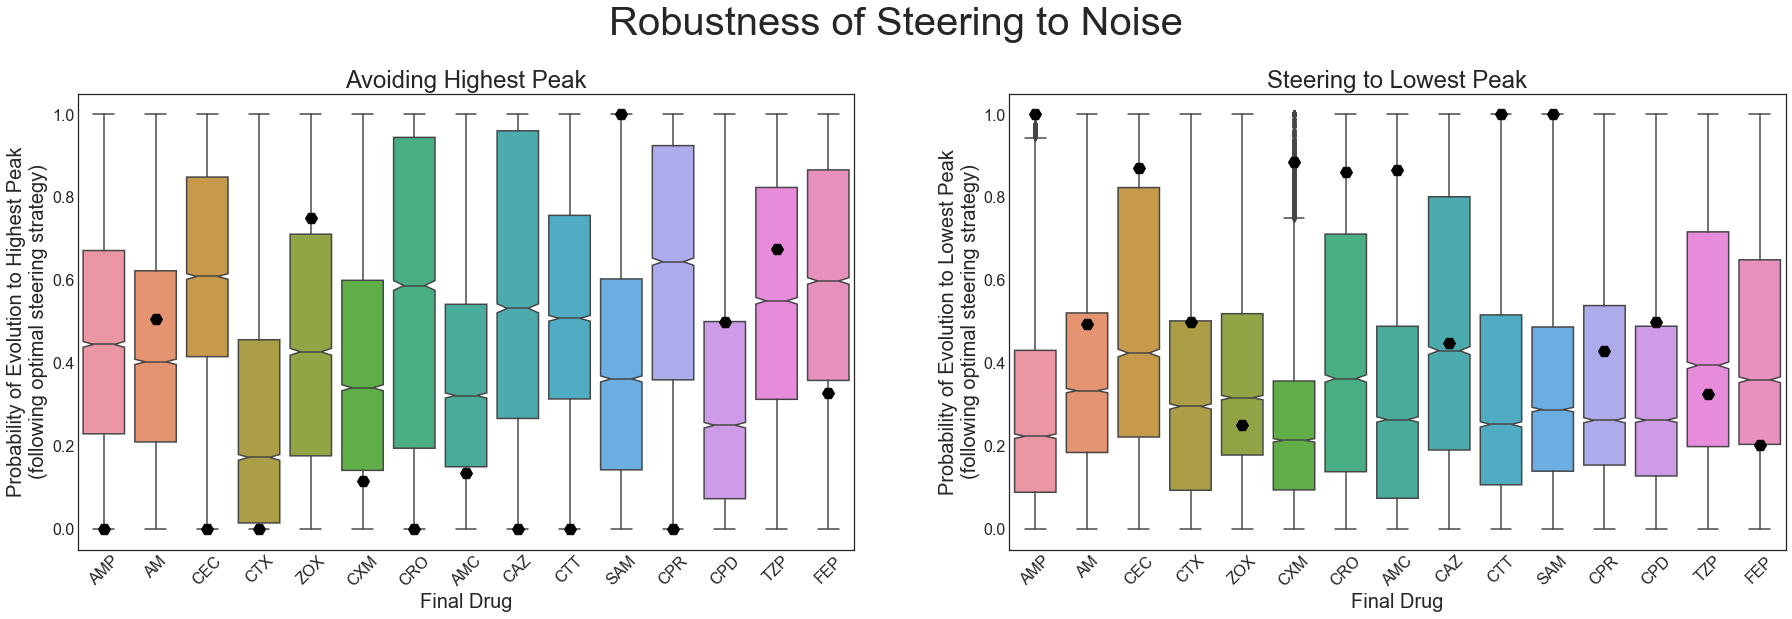

In [463]:
plt.figure(figsize=(25,9))
plt.subplot(121)
sns.boxplot(data=dists, notch=True)

for k, p in enumerate(ps_hp):
    plt.plot([k],[p], marker='H', c='k', markersize=12)

plt.xticks(range(15), labs, rotation=45, size=16)
plt.yticks(size=16)
plt.xlabel('Final Drug', size=20)
plt.ylabel('''Probability of Evolution to Highest Peak\n
(following optimal steering strategy)''', size=20)
plt.title('Avoiding Highest Peak', size=24)

plt.subplot(122)
sns.boxplot(data=dists_l, notch=True)

for k, p in enumerate(ps_lp):
    plt.plot([k],[p], marker='H', c='k', markersize=12)

plt.xticks(range(15), labs, rotation=45, size=16)
plt.yticks(size=16)
plt.xlabel('Final Drug', size=20)
plt.ylabel('''Probability of Evolution to Lowest Peak
           \n(following optimal steering strategy)''', size=20)
plt.title('Steering to Lowest Peak', size=24)

plt.suptitle('Robustness of Steering to Noise', size=40)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.subplots_adjust(wspace=0.2)